In [217]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import nibabel as nib
import os

sys.path.insert(1, '/home/quahb/caipi_denoising/src')

%load_ext autoreload
%autoreload 2

from utils.data_io import load_dataset

from evaluation.compute_metrics import psnr, ssim, cnr, luminance, contrast, structure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data and masks

In [2]:
train_data = load_dataset('/home/quahb/caipi_denoising/data/datasets/training_set_pp')
test_data = load_dataset('/home/quahb/caipi_denoising/data/datasets/testing_set_pp')
print(list(train_data.keys())[:10], list(test_data.keys())[:10])

['1_01_016-V1_3D_T2STAR_segEPI', '1_01_017-V1_3D_T2STAR_segEPI', '1_01_018-V1_3D_T2STAR_segEPI', '1_01_020-V1_3D_T2STAR_segEPI', '1_01_021-V1_3D_T2STAR_segEPI', '1_01_022-V1_3D_T2STAR_segEPI', '1_01_024-V1_3D_T2STAR_segEPI', '1_01_025-V1_3D_T2STAR_segEPI', '1_01_026-V1_3D_T2STAR_segEPI', '1_01_028-V1_3D_T2STAR_segEPI'] ['1_01_016-V1_CAIPI1x2', '1_01_016-V1_CAIPI1x3', '1_01_016-V1_CAIPI2x2', '1_01_017-V1_CAIPI1x2', '1_01_017-V1_CAIPI1x3', '1_01_017-V1_CAIPI2x2', '1_01_018-V1_CAIPI1x2', '1_01_018-V1_CAIPI1x3', '1_01_018-V1_CAIPI2x2', '1_01_020-V1_CAIPI1x2']


In [234]:
train_data['1_01_016-V1_3D_T2STAR_segEPI'][0].shape

(384, 312, 256)

In [154]:
# ps256_th_singlenoise_m3_test
# ps256_th_varynoise_m3_test
config_name = 'ps256_th_varynoise_m3_test'
denoised = load_dataset('/home/quahb/caipi_denoising/data/results/' + config_name)

In [5]:
# merge train, test into single set

dataset = {} # subj_id: (unacc, caipi2, caipi3, caipi4)

train_keys = sorted(train_data.keys())
test_keys  = sorted(test_data.keys())

for key_i in range(len(train_keys)):
    subj_id = '_'.join(train_keys[key_i].split('_')[:3])
    caipi1_data = train_data[train_keys[key_i]][0]
    caipi2_data = test_data[test_keys[key_i * 3]][0]
    caipi3_data = test_data[test_keys[key_i * 3 + 1]][0]
    caipi4_data = test_data[test_keys[key_i * 3 + 2]][0]
    
    dataset[subj_id] = (caipi1_data, caipi2_data, caipi3_data, caipi4_data)

len(dataset.keys()), dataset.keys()

(63,
 dict_keys(['1_01_016-V1', '1_01_017-V1', '1_01_018-V1', '1_01_020-V1', '1_01_021-V1', '1_01_022-V1', '1_01_024-V1', '1_01_025-V1', '1_01_026-V1', '1_01_028-V1', '1_01_029-V1', '1_01_031-V1', '1_01_032-V1', '1_01_034-V1', '1_01_035-V1', '1_01_036-V1', '1_01_037-V1-2', '1_01_037-V1', '1_01_038-V1', '1_01_039-V1', '1_01_040-V1', '1_01_041-V1', '1_07_003-V1', '1_07_004-V1', '1_07_005-V1', '1_07_006-V1', '1_07_007-V1', '1_07_009-V1', '1_07_010-V1', '1_07_011-V1', '1_07_013-V1', '1_07_017-V1', '1_07_021-V1', '1_07_022-V1', '1_07_023-V1', '1_07_025-V1', '1_07_028-V1', '1_07_029-V1', '1_07_030-V1', '1_07_031-V1', '1_07_032-V1', '1_07_034-V1', '1_07_036-V1', '1_07_037-V1', '1_07_038-V1', '1_07_039-V1', '1_07_045-V1', '1_07_047-V1', '1_07_051-V1', '1_07_056-V1', '1_08_032-V1', '1_08_035-V1', '1_08_036-V1', '1_08_042-V1', '1_08_044-V1', '1_08_045-V1', '1_08_046-V1', '1_08_047-V1', '1_08_049-V1', '1_08_050-V1', '1_08_054-V1', '1_08_055-V1', '1_08_056-V1']))

In [225]:
# load and process masks
# {subj_id: 
#     {vein: data, 
#      white_matter: data,
#      lesion: data
#     }
# }
all_masks = {} 
masks_dir = '/home/quahb/caipi_denoising/data/EPI_CAIPI/'

vein_fname = 'vein_mask.nii.gz'
wm_fname   = 'probability_map.nii.gz'
lesion_fname = 'mimosa_binary_mask_0.05.nii.gz'

subjs = os.listdir(masks_dir)

In [223]:
for subj in subjs:
    os.path.join(masks_dir, subj)

63

In [6]:
# load and process masks
wm_map = nib.load('/home/quahb/caipi_denoising/data/source_masks/01_016/WM_mask.nii.gz').get_fdata()
vein_map = nib.load('/home/quahb/caipi_denoising/data/source_masks/01_016/Vein_mask_Reg.nii.gz').get_fdata()
lesion_map = nib.load('/home/quahb/caipi_denoising/data/source_masks/01_016/Lesion_map.nii.gz').get_fdata()
wm_map = np.moveaxis(wm_map, 0, 1)
vein_map = np.moveaxis(vein_map, 0, 1)
lesion_map = np.moveaxis(lesion_map, 0, 1)

print(wm_map.shape, vein_map.shape, lesion_map.shape)
print(np.min(wm_map), np.max(wm_map), np.mean(wm_map))
print(np.min(vein_map), np.max(vein_map), np.mean(vein_map))
print(np.min(lesion_map), np.max(lesion_map), np.mean(lesion_map))

(384, 312, 256) (384, 312, 256) (384, 312, 256)
0.0 1.0 0.07752907615865577
0.0 1.0 0.004849001675141223
0.0 0.9427834749221802 0.0014162343984977428


In [119]:
vein_mask     = np.flip(np.array(vein_map > 0.98, dtype=np.uint8), axis=2)
wm_mask       = np.flip(np.array(wm_map > 0.8, dtype=np.uint8), axis=2)
lesion_mask   = np.flip(np.array(lesion_map > 0.6, dtype=np.uint8), axis=2)

masks = {}
masks['1_01_016-V1'] = (wm_mask, lesion_mask, vein_mask)

# Plot 

- Unaccelerated -- Caipi1x2 -- Caipi1x3 -- Caipi2x2
- Full volume metrics: pSNR -- SSIM -- CNR WMV/LV

In [214]:
def plot_dataset(dataset, masks=None, slc_index=128, mode='sagittal', add_noise=False):
    '''
        dataset is dictionary of 4 tuples:
            dataset = {'subj_id': (data1, data2, data3, data4)}
        masks is dictionary of 3 tuples:
            masks = {'subj_id': (wm_mask, lesion_mask, vein_mask)}
    '''
    n_rows, n_cols = 1, 4

    figure, axis = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 8))
    print('Plotting {}/{} subjects...'.format(n_rows, len(dataset.keys())))
    
    # Iterate over all subject IDs
    for i, subj_id in enumerate(list(dataset.keys())[:n_rows]):
        # Get data
        caipi1, caipi2, caipi3, caipi4 = dataset[subj_id]

        if add_noise:
            std = 0.1
            caipi1 = caipi1 + np.random.normal(0, std, caipi1.shape)
            caipi2 = caipi2 + np.random.normal(0, std, caipi2.shape)
            caipi3 = caipi3 + np.random.normal(0, std, caipi3.shape)
            caipi4 = caipi4 + np.random.normal(0, std, caipi4.shape)

        # Compute full volume metrics
        psnr_vals = [ psnr(caipi1), psnr(caipi2), psnr(caipi3), psnr(caipi4) ]
        #psnr_vals = [0, 0, 0, 0]
        ssim_vals = [ ssim(caipi1, caipi1), ssim(caipi1, caipi2), ssim(caipi1, caipi3), ssim(caipi1, caipi4) ]
        #ssim_vals = [0, 0, 0, 0]  # ssim has long compute time
        lumi_vals   = [ luminance(caipi1, caipi1), luminance(caipi1, caipi2), luminance(caipi1, caipi3), luminance(caipi1, caipi4) ]
        cont_vals   = [ contrast(caipi1, caipi1), contrast(caipi1, caipi2), contrast(caipi1, caipi3), contrast(caipi1, caipi4) ]
        struct_vals = [ structure(caipi1, caipi1), structure(caipi1, caipi2), structure(caipi1, caipi3), structure(caipi1, caipi4) ]
        
        if masks is not None:
            wm_mask, lesion_mask, vein_mask = masks[subj_id]
            
            cnr_vals = [ 
                    (cnr(caipi1, wm_mask, vein_mask), cnr(caipi1, lesion_mask, vein_mask)),
                    (cnr(caipi2, wm_mask, vein_mask), cnr(caipi2, lesion_mask, vein_mask)),
                    (cnr(caipi3, wm_mask, vein_mask), cnr(caipi3, lesion_mask, vein_mask)),
                    (cnr(caipi4, wm_mask, vein_mask), cnr(caipi4, lesion_mask, vein_mask)),
            ]
            #cnr_vals = [ (0, 0), (0, 0), (0, 0), (0, 0)]

        if mode == 'axial':
            caipi1 = caipi1[slc_index,:,:]
            caipi2 = caipi2[slc_index,:,:]
            caipi3 = caipi3[slc_index,:,:]
            caipi4 = caipi4[slc_index,:,:]
        elif mode == 'coronal':
            caipi1 = caipi1[:,slc_index,:]
            caipi2 = caipi2[:,slc_index,:]
            caipi3 = caipi3[:,slc_index,:]
            caipi4 = caipi4[:,slc_index,:]
        elif mode == 'sagittal':
            caipi1 = caipi1[:,:,slc_index]
            caipi2 = caipi2[:,:,slc_index]
            caipi3 = caipi3[:,:,slc_index]
            caipi4 = caipi4[:,:,slc_index]
        elif mode == 'axial_masks':
            caipi1 = caipi1[slc_index,:,:]
            caipi2 = wm_mask[slc_index,:,:]
            caipi3 = lesion_mask[slc_index,:,:]
            caipi4 = vein_mask[slc_index,:,:]

        bottom_text = 'PSNR: {:.2f}, SSIM: {:.2f}, CNR (V-WM, V-L): {:.3f}, {:.3f} \n' + \
                        'min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}' # 'Lum: {:.2f}, Cont: {:.2f}, Struct: {:.2f} \n' + \
        # bottom_text = 'PSNR: {:.2f}, SSIM: {:.2f} \n' + \
        #                 'min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}' # 'Lum: {:.2f}, Cont: {:.2f}, Struct: {:.2f} \n' + \

        # Plot data
        axis[0].imshow(caipi1, cmap='gray')
        axis[0].set_title(f'{subj_id}')
        axis[0].set(xlabel=bottom_text.format(
            psnr_vals[0], ssim_vals[0], cnr_vals[0][0], cnr_vals[0][1],
            #lumi_vals[0], cont_vals[0], struct_vals[0],
            np.min(caipi1), np.max(caipi1), np.mean(caipi1), np.std(caipi1)))
        
        axis[1].imshow(caipi2, cmap='gray')
        axis[1].set_title('CAIPI 2')
        axis[1].set(xlabel=bottom_text.format(
            psnr_vals[1], ssim_vals[1], cnr_vals[1][0], cnr_vals[1][1],
            #lumi_vals[1], cont_vals[1], struct_vals[1],
            np.min(caipi2), np.max(caipi2), np.mean(caipi2), np.std(caipi2)))
        
        axis[2].imshow(caipi3, cmap='gray')
        axis[2].set_title('CAIPI 3')
        axis[2].set(xlabel=bottom_text.format(
            psnr_vals[2], ssim_vals[2], cnr_vals[2][0], cnr_vals[2][1],
            #lumi_vals[2], cont_vals[2], struct_vals[2],
            np.min(caipi3), np.max(caipi3), np.mean(caipi3), np.std(caipi3)))
        
        axis[3].imshow(caipi4, cmap='gray')
        axis[3].set_title('CAIPI 4')
        axis[3].set(xlabel=bottom_text.format(
            psnr_vals[3], ssim_vals[3], cnr_vals[3][0], cnr_vals[3][1],
            #lumi_vals[3], cont_vals[3], struct_vals[3],
            np.min(caipi4), np.max(caipi4), np.mean(caipi4), np.std(caipi4)))

    plt.show()

Plotting 1/63 subjects...


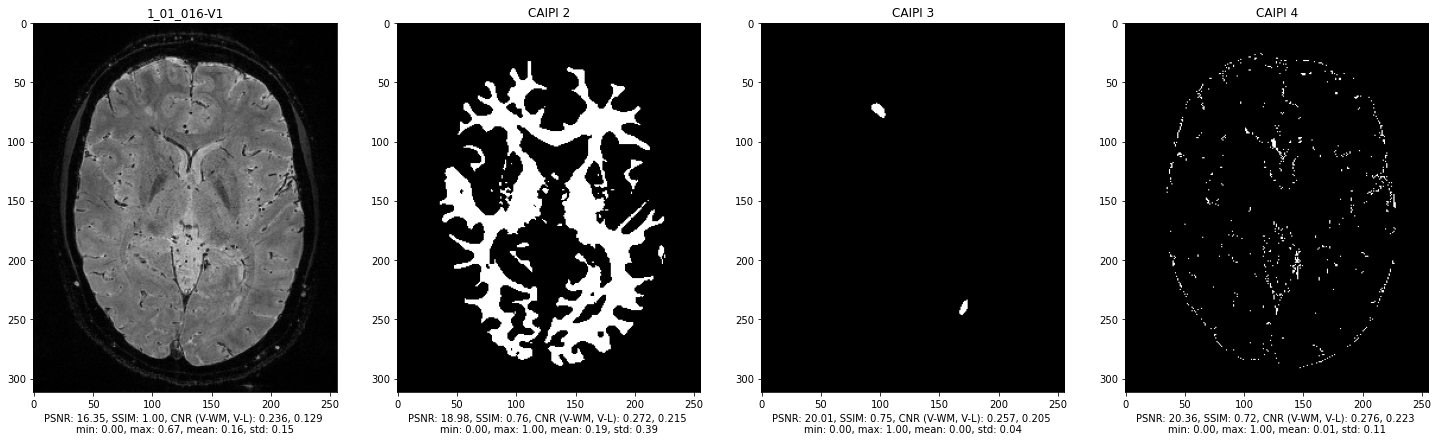

In [216]:
plot_dataset(dataset, 
             masks=masks,
             slc_index=146,
             mode='axial_masks',
             add_noise=False)

Plotting 1/63 subjects...
0.02318081315138446
0.012656096332091802
0.009986285566727033
0.009207420818839462


/home/quahb/.conda/envs/caipi_denoising/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/quahb/caipi_denoising/src/evaluation/compute_metrics.py:105: RuntimeWarning: invalid value encountered in double_scalars
  


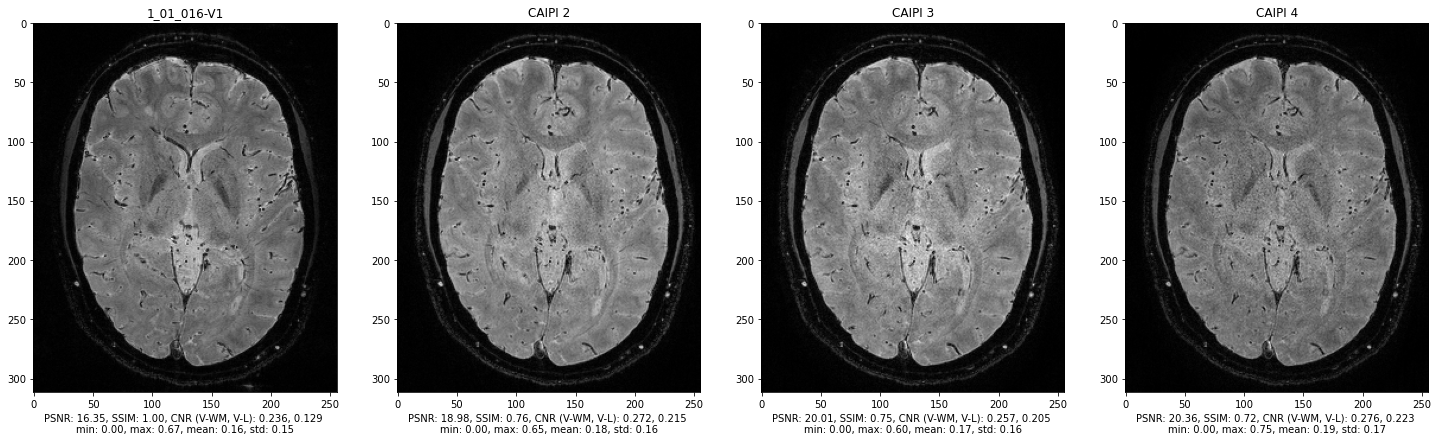

In [226]:
plot_dataset(dataset, 
             masks=masks,
             slc_index=146,
             mode='axial',
             add_noise=False)

Plotting 1/63 subjects...
0.023027168419900754
0.013013839023662554
0.010301282457700005
0.00964575428998806


/home/quahb/caipi_denoising/src/evaluation/compute_metrics.py:105: RuntimeWarning: invalid value encountered in double_scalars
  


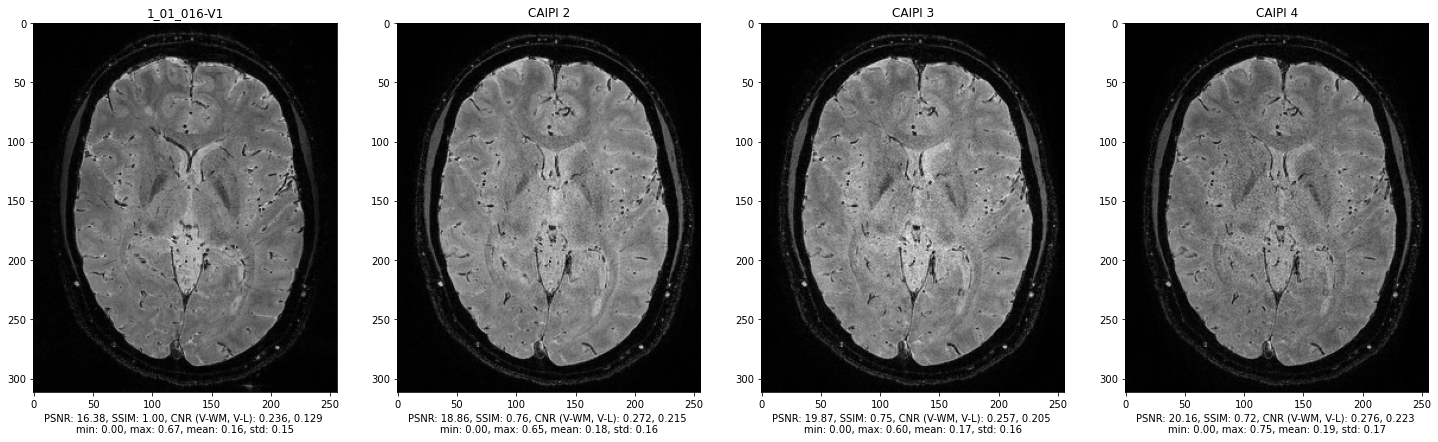

In [228]:
plot_dataset(dataset, 
             masks=masks,
             slc_index=146,
             mode='axial',
             add_noise=False)

# Plot 

- Unaccelerated -- CAIPI -- Denoised
native caipi2 denoised2
native caipi3 denoised3
native caipi4 denoised4

In [161]:
dataset.keys(),denoised.keys()

(dict_keys(['1_01_016-V1', '1_01_017-V1', '1_01_018-V1', '1_01_020-V1', '1_01_021-V1', '1_01_022-V1', '1_01_024-V1', '1_01_025-V1', '1_01_026-V1', '1_01_028-V1', '1_01_029-V1', '1_01_031-V1', '1_01_032-V1', '1_01_034-V1', '1_01_035-V1', '1_01_036-V1', '1_01_037-V1-2', '1_01_037-V1', '1_01_038-V1', '1_01_039-V1', '1_01_040-V1', '1_01_041-V1', '1_07_003-V1', '1_07_004-V1', '1_07_005-V1', '1_07_006-V1', '1_07_007-V1', '1_07_009-V1', '1_07_010-V1', '1_07_011-V1', '1_07_013-V1', '1_07_017-V1', '1_07_021-V1', '1_07_022-V1', '1_07_023-V1', '1_07_025-V1', '1_07_028-V1', '1_07_029-V1', '1_07_030-V1', '1_07_031-V1', '1_07_032-V1', '1_07_034-V1', '1_07_036-V1', '1_07_037-V1', '1_07_038-V1', '1_07_039-V1', '1_07_045-V1', '1_07_047-V1', '1_07_051-V1', '1_07_056-V1', '1_08_032-V1', '1_08_035-V1', '1_08_036-V1', '1_08_042-V1', '1_08_044-V1', '1_08_045-V1', '1_08_046-V1', '1_08_047-V1', '1_08_049-V1', '1_08_050-V1', '1_08_054-V1', '1_08_055-V1', '1_08_056-V1']),
 dict_keys(['1_01_016-V1_CAIPI1x2', '1_

In [209]:
def plot_result(dataset, denoised, masks=None, slc_index=128, mode='sagittal'):
    '''
        dataset is dictionary of 4 tuples:
            dataset = {'subj_id': (data1, data2, data3, data4)}
        denoised is dictionary of 2 tuples:
            denoised = {'subj_id': (input_image, output_image)}
        masks is dictionary of 3 tuples:
            masks = {'subj_id': (wm_mask, vein_mask, lesion_mask)}

        {'subj_id': (data1, data2, data3, data4, denoised, vein_mask, lesion_mask, wm_mask)}
    '''
    show_subj = 1
    n_rows, n_cols = 3 * show_subj, 3

    figure, axis = plt.subplots(n_rows, n_cols, figsize=(24, n_rows * 10))
    print('Plotting {}/{} subjects...'.format(show_subj, len(dataset.keys())))
    
    subj_ids = sorted(list(dataset.keys()))
    subj_ids_modalities = sorted(list(denoised.keys()))
    
    for ii in range(len(subj_ids))[:show_subj]:
        cur_subj_id = subj_ids[ii]
        caipi1, caipi2, caipi3, caipi4 = dataset[cur_subj_id]
        denoised_cp2_in, denoised_cp2_out = denoised[subj_ids_modalities[ii * 3]]
        denoised_cp3_in, denoised_cp3_out = denoised[subj_ids_modalities[ii * 3 + 1]]
        denoised_cp4_in, denoised_cp4_out = denoised[subj_ids_modalities[ii * 3 + 2]]
        # native caipi2 denoised2
        # native caipi3 denoised3
        # native caipi4 denoised4
        
        # Compute full volume metrics
        psnr_vals = [ psnr(caipi1), 
                        (psnr(caipi2), psnr(denoised_cp2_out)), 
                        (psnr(caipi3), psnr(denoised_cp3_out)),
                        (psnr(caipi4), psnr(denoised_cp2_out)) ]
        # psnr_vals = [0, (0, 0), (0, 0), (0, 0)]
        # ssim_vals = [ ssim(caipi1, caipi1),
        #                 (ssim(caipi1, caipi2), ssim(caipi1, denoised_cp2_out)),
        #                 (ssim(caipi1, caipi3), ssim(caipi1, denoised_cp3_out)),
        #                 (ssim(caipi1, caipi4), ssim(caipi1, denoised_cp4_out)) ]
        ssim_vals   = [0, (0, 0), (0, 0), (0, 0)]  # ssim has long compute time
        # lumi_vals   = [ luminance(caipi1, caipi1), luminance(caipi1, caipi2), luminance(caipi1, caipi3), luminance(caipi1, caipi4) ]
        # cont_vals   = [ contrast(caipi1, caipi1), contrast(caipi1, caipi2), contrast(caipi1, caipi3), contrast(caipi1, caipi4) ]
        # struct_vals = [ structure(caipi1, caipi1), structure(caipi1, caipi2), structure(caipi1, caipi3), structure(caipi1, caipi4) ]
        
        if masks is not None:
            wm_mask, lesion_mask, vein_mask = masks[cur_subj_id]
            
            cnr_vals = [ # 4 items
                    ( cnr(caipi1, wm_mask, vein_mask), cnr(caipi1, lesion_mask, vein_mask)
                    ),
                    ( (cnr(caipi2, wm_mask, vein_mask), cnr(caipi2, lesion_mask, vein_mask)),
                      (cnr(denoised_cp2_out, wm_mask, vein_mask), cnr(denoised_cp2_out, lesion_mask, vein_mask)),
                    ),
                    ( (cnr(caipi3, wm_mask, vein_mask), cnr(caipi3, lesion_mask, vein_mask)),
                      (cnr(denoised_cp3_out, wm_mask, vein_mask), cnr(denoised_cp3_out, lesion_mask, vein_mask)),
                    ),
                    ( (cnr(caipi4, wm_mask, vein_mask), cnr(caipi4, lesion_mask, vein_mask)),
                      (cnr(denoised_cp4_out, wm_mask, vein_mask), cnr(denoised_cp4_out, lesion_mask, vein_mask)),
                    )
            ]
            # cnr_vals = [ (0, 0), 
            #             ( (0, 0), (0, 0) ),
            #             ( (0, 0), (0, 0) ),
            #             ( (0, 0), (0, 0) ) ]

        if mode == 'axial':
            caipi1 = caipi1[slc_index,:,:]
            caipi2 = caipi2[slc_index,:,:]
            caipi3 = caipi3[slc_index,:,:]
            caipi4 = caipi4[slc_index,:,:]
            denoised_cp2_in  = denoised_cp2_in[slc_index,:,:]
            denoised_cp2_out = denoised_cp2_out[slc_index,:,:]
            denoised_cp3_in  = denoised_cp3_in[slc_index,:,:]
            denoised_cp3_out = denoised_cp3_out[slc_index,:,:]
            denoised_cp4_in  = denoised_cp4_in[slc_index,:,:]
            denoised_cp4_out = denoised_cp4_out[slc_index,:,:]
        elif mode == 'coronal':
            caipi1 = caipi1[:,slc_index,:]
            caipi2 = caipi2[:,slc_index,:]
            caipi3 = caipi3[:,slc_index,:]
            caipi4 = caipi4[:,slc_index,:]
            denoised_cp2_in  = denoised_cp2_in[:,slc_index,:]
            denoised_cp2_out = denoised_cp2_out[:,slc_index,:]
            denoised_cp3_in  = denoised_cp3_in[:,slc_index,:]
            denoised_cp3_out = denoised_cp3_out[:,slc_index,:]
            denoised_cp4_in  = denoised_cp4_in[:,slc_index,:]
            denoised_cp4_out = denoised_cp4_out[:,slc_index,:]
        elif mode == 'sagittal':
            caipi1 = caipi1[:,:,slc_index]
            caipi2 = caipi2[:,:,slc_index]
            caipi3 = caipi3[:,:,slc_index]
            caipi4 = caipi4[:,:,slc_index]
            denoised_cp2_in  = denoised_cp2_in[:,:,slc_index]
            denoised_cp2_out = denoised_cp2_out[:,:,slc_index]
            denoised_cp3_in  = denoised_cp3_in[:,:,slc_index]
            denoised_cp3_out = denoised_cp3_out[:,:,slc_index]
            denoised_cp4_in  = denoised_cp4_in[:,:,slc_index]
            denoised_cp4_out = denoised_cp4_out[:,:,slc_index]

        bottom_text = 'PSNR: {:.2f}, SSIM: {:.2f}, CNR (V-WM, V-L): {:.3f}, {:.3f} \n' + \
                        'min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}' # 'Lum: {:.2f}, Cont: {:.2f}, Struct: {:.2f} \n' + \
        
        # Plot data
        # Native-CAIPI2-Denoised
        axis[ii * 3, 0].imshow(caipi1, cmap='gray')
        axis[ii * 3, 0].set_title(f'{cur_subj_id}')
        axis[ii * 3, 0].set(xlabel=bottom_text.format(
            psnr_vals[0], ssim_vals[0], cnr_vals[0][0], cnr_vals[0][1],
            #lumi_vals[0], cont_vals[0], struct_vals[0],
            np.min(caipi1), np.max(caipi1), np.mean(caipi1), np.std(caipi1)))
        axis[ii * 3, 1].imshow(caipi2, cmap='gray')
        axis[ii * 3, 1].set_title('CAIPI 2')
        axis[ii * 3, 1].set(xlabel=bottom_text.format(
            psnr_vals[1][0], ssim_vals[1][0], cnr_vals[1][0][0], cnr_vals[1][0][1],
            #lumi_vals[1], cont_vals[1], struct_vals[1],
            np.min(caipi2), np.max(caipi2), np.mean(caipi2), np.std(caipi2)))
        axis[ii * 3, 2].imshow(denoised_cp2_out, cmap='gray')
        axis[ii * 3, 2].set_title('Denoised')
        axis[ii * 3, 2].set(xlabel=bottom_text.format(
            psnr_vals[1][1], ssim_vals[1][1], cnr_vals[1][1][0], cnr_vals[1][1][1],
            #lumi_vals[2], cont_vals[2], struct_vals[2],
            np.min(denoised_cp2_out), np.max(denoised_cp2_out), np.mean(denoised_cp2_out), np.std(denoised_cp2_out)))

        # Native-CAIPI3-Denoised
        axis[ii * 3 + 1, 0].imshow(caipi1, cmap='gray')
        axis[ii * 3 + 1, 0].set_title(f'{cur_subj_id}')
        axis[ii * 3 + 1, 0].set(xlabel=bottom_text.format(
            psnr_vals[0], ssim_vals[0], cnr_vals[0][0], cnr_vals[0][1],
            #lumi_vals[0], cont_vals[0], struct_vals[0],
            np.min(caipi1), np.max(caipi1), np.mean(caipi1), np.std(caipi1)))
        axis[ii * 3 + 1, 1].imshow(caipi3, cmap='gray')
        axis[ii * 3 + 1, 1].set_title('CAIPI 3')
        axis[ii * 3 + 1, 1].set(xlabel=bottom_text.format(
            psnr_vals[2][0], ssim_vals[2][0], cnr_vals[2][0][0], cnr_vals[2][0][1],
            #lumi_vals[1], cont_vals[1], struct_vals[1],
            np.min(caipi3), np.max(caipi3), np.mean(caipi3), np.std(caipi3)))
        axis[ii * 3 + 1, 2].imshow(denoised_cp3_out, cmap='gray')
        axis[ii * 3 + 1, 2].set_title('Denoised')
        axis[ii * 3 + 1, 2].set(xlabel=bottom_text.format(
            psnr_vals[2][1], ssim_vals[2][1], cnr_vals[2][1][0], cnr_vals[2][1][1],
            #lumi_vals[2], cont_vals[2], struct_vals[2],
            np.min(denoised_cp3_out), np.max(denoised_cp3_out), np.mean(denoised_cp3_out), np.std(denoised_cp3_out)))

        # Native-CAIPI4-Denoised
        axis[ii * 3 + 2, 0].imshow(caipi1, cmap='gray')
        axis[ii * 3 + 2, 0].set_title(f'{cur_subj_id}')
        axis[ii * 3 + 2, 0].set(xlabel=bottom_text.format(
            psnr_vals[0], ssim_vals[0], cnr_vals[0][0], cnr_vals[0][1],
            #lumi_vals[0], cont_vals[0], struct_vals[0],
            np.min(caipi1), np.max(caipi1), np.mean(caipi1), np.std(caipi1)))
        axis[ii * 3 + 2, 1].imshow(caipi4, cmap='gray')
        axis[ii * 3 + 2, 1].set_title('CAIPI 4')
        axis[ii * 3 + 2, 1].set(xlabel=bottom_text.format(
            psnr_vals[3][0], ssim_vals[3][0], cnr_vals[3][0][0], cnr_vals[3][0][1],
            #lumi_vals[1], cont_vals[1], struct_vals[1],
            np.min(caipi4), np.max(caipi4), np.mean(caipi4), np.std(caipi4)))
        axis[ii * 3 + 2, 2].imshow(denoised_cp4_out, cmap='gray')
        axis[ii * 3 + 2, 2].set_title('Denoised')
        axis[ii * 3 + 2, 2].set(xlabel=bottom_text.format(
            psnr_vals[3][1], ssim_vals[3][1], cnr_vals[3][1][0], cnr_vals[3][1][1],
            #lumi_vals[2], cont_vals[2], struct_vals[2],
            np.min(denoised_cp4_out), np.max(denoised_cp4_out), np.mean(denoised_cp4_out), np.std(denoised_cp4_out)))

    plt.show()

Plotting 1/63 subjects...


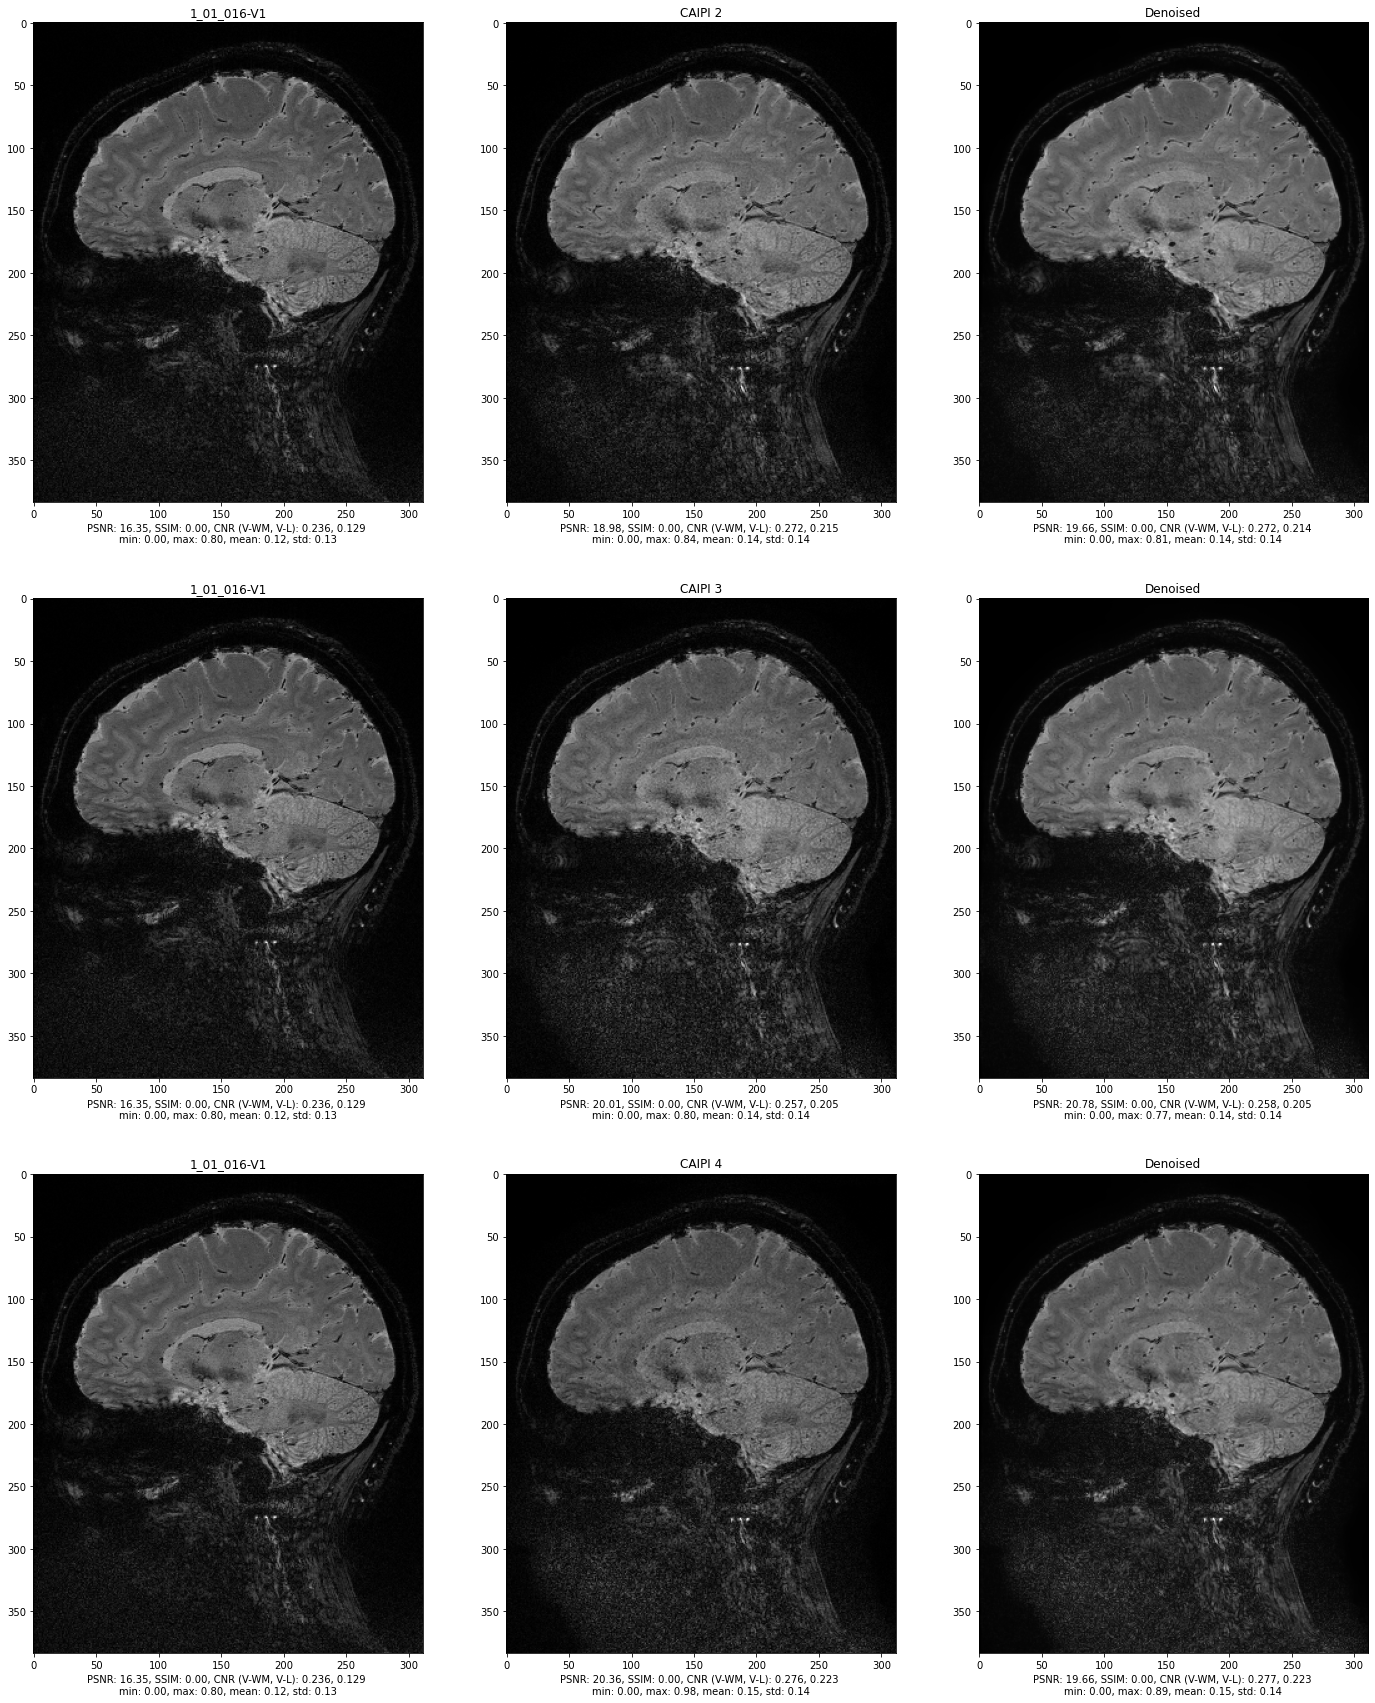

In [211]:
plot_result(dataset, 
            denoised,
            masks=masks,
            slc_index=146,
            mode='sagittal')